In [1]:
!pip install split-folders

In [2]:
import os
import random
import numpy as np
import cv2
import splitfolders
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sn

import tensorflow as tf
from tensorflow.keras.applications import VGG16
from keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras import layers, models, Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing import image, image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix

from matplotlib.ticker import (MultipleLocator, FormatStrFormatter)
from dataclasses import dataclass

In [3]:
SEED_VALUE = 42

# Fix seed to make training deterministic.
random.seed(SEED_VALUE)
np.random.seed(SEED_VALUE)
tf.random.set_seed(SEED_VALUE)

In [5]:
input_data_dir = '/content/drive/MyDrive/animals' # path to dataset
output_dir = '/content/drive/MyDrive' # path to save data
splitfolders.ratio(input_data_dir, output=output_dir, seed=3, ratio=(.8, .2)) # default values

Copying files: 3000 files [01:43, 28.88 files/s]


In [4]:
train_data_dir = '/content/drive/MyDrive/train'
test_data_dir = '/content/drive/MyDrive/test'

batch_size = 32
img_height = 224
img_width = 224


# Step 1: Load images using Keras ImageDataGenerator flow_from_directory API.
# Apply Data Augmentation
augmented_datagen = ImageDataGenerator(rescale=1./255,
                                       rotation_range=20,
                                       width_shift_range=0.2,
                                       height_shift_range=0.2,
                                       zoom_range=0.2,
                                       validation_split = 0.1,
                                       horizontal_flip=True)

test_generator = ImageDataGenerator(rescale=1./255)

In [5]:
train_data = augmented_datagen.flow_from_directory(train_data_dir,
                                       target_size=(img_height, img_width),
                                       batch_size=batch_size,
                                       subset = "training",
                                       class_mode = 'categorical')

validation_data = augmented_datagen.flow_from_directory(train_data_dir,
                                       target_size=(img_height, img_width),
                                       batch_size=batch_size,
                                       subset = "validation",
                                       class_mode = 'categorical')

test_data = test_generator.flow_from_directory(
    test_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode="categorical",
    shuffle = False
)

Found 2160 images belonging to 3 classes.
Found 240 images belonging to 3 classes.
Found 600 images belonging to 3 classes.


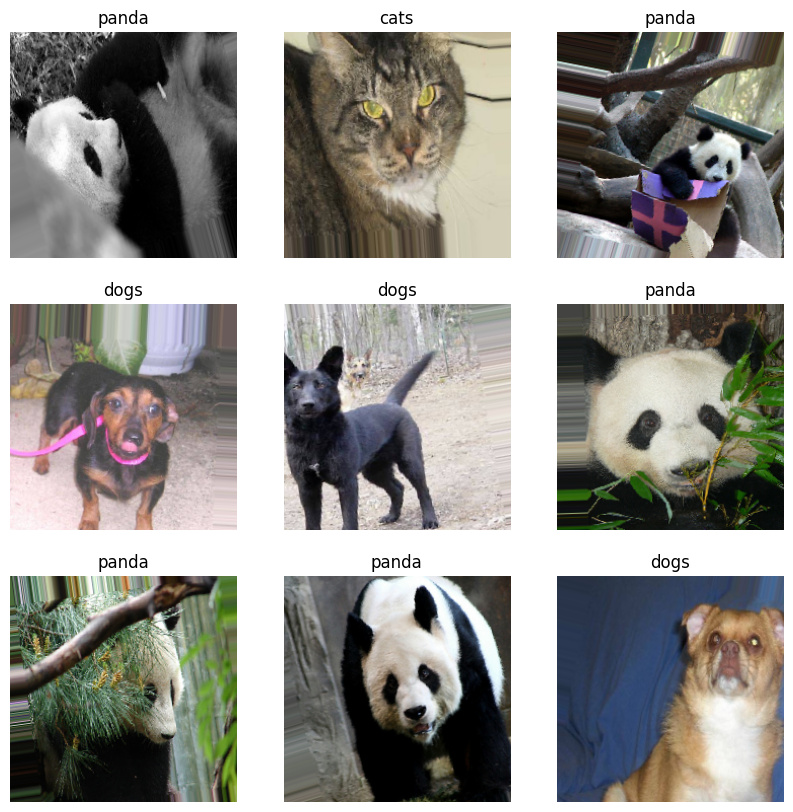

In [6]:
sample_images, sample_labels = next(train_data)
plt.figure(figsize=(10, 10))
class_names = list(train_data.class_indices.keys())  # Convert dict_keys object to list

for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(sample_images[i])
    plt.title(class_names[np.argmax(sample_labels[i])])  # Access class names using list indexing
    plt.axis("off")
plt.show()

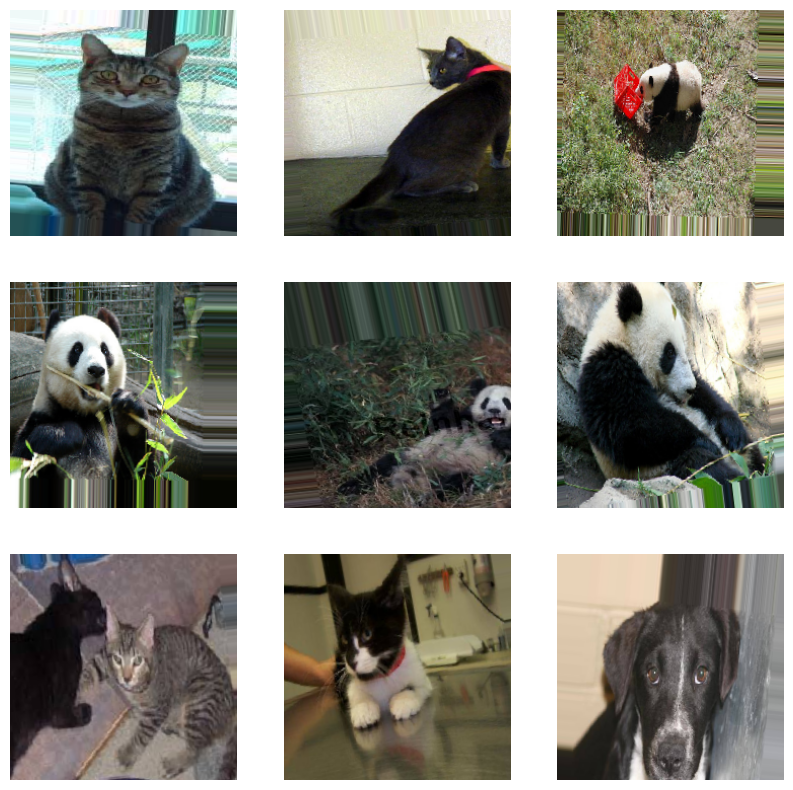

In [7]:
# Step 4: Display augmented images
augmented_images, _ = next(train_data)
plt.figure(figsize=(10, 10))
class_names = list(train_data.class_indices.keys())  # Convert dict_keys object to list
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[i])
    plt.axis("off")
plt.show()

In [9]:
input_shape = (img_height,img_width,3)
num_class = 3
learning_rate = 0.001
loss = 'categorical_crossentropy'
output_activation = 'softmax'
epochs = 10

In [10]:
from tensorflow.keras.applications import MobileNetV2

base_model = MobileNetV2(include_top=False,
                   weights='imagenet',
                   input_shape=input_shape)

base_model.summary()

9406464/9406464 [==============================] - 0s 0us/step
Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 112, 112, 32)         864       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 112, 112, 32)         128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReL

In [11]:
# Free the convolutional base of the model
base_model.trainable = False

In [12]:
model = Sequential([
    base_model,
    Flatten(),
    Dense(256, activation='relu'),
    Dense(num_class, activation='softmax')
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Func  (None, 7, 7, 1280)        2257984   
 tional)                                                         
                                                                 
 flatten (Flatten)           (None, 62720)             0         
                                                                 
 dense (Dense)               (None, 256)               16056576  
                                                                 
 dense_1 (Dense)             (None, 3)                 771       
                                                                 
Total params: 18315331 (69.87 MB)
Trainable params: 16057347 (61.25 MB)
Non-trainable params: 2257984 (8.61 MB)
_________________________________________________________________


In [14]:
model.compile(optimizer=Adam(learning_rate = learning_rate),
              loss=loss,
              metrics=['accuracy'])

In [15]:
history = model.fit(train_data,
                    epochs = epochs,
                    validation_data = validation_data,
                    batch_size = batch_size,
                    verbose = 1)

Epoch 1/10
68/68 [==============================] - 353s 5s/step - loss: 2.2024 - accuracy: 0.9199 - val_loss: 1.1014 - val_accuracy: 0.9417
Epoch 2/10
68/68 [==============================] - 41s 610ms/step - loss: 0.8133 - accuracy: 0.9574 - val_loss: 0.3052 - val_accuracy: 0.9875
Epoch 3/10
68/68 [==============================] - 41s 606ms/step - loss: 0.5146 - accuracy: 0.9648 - val_loss: 0.1380 - val_accuracy: 0.9875
Epoch 4/10
68/68 [==============================] - 43s 632ms/step - loss: 0.3872 - accuracy: 0.9630 - val_loss: 0.0839 - val_accuracy: 0.9750
Epoch 5/10
68/68 [==============================] - 41s 605ms/step - loss: 0.2523 - accuracy: 0.9694 - val_loss: 0.0783 - val_accuracy: 0.9833
Epoch 6/10
68/68 [==============================] - 41s 611ms/step - loss: 0.2328 - accuracy: 0.9685 - val_loss: 0.2244 - val_accuracy: 0.9625
Epoch 7/10
68/68 [==============================] - 42s 617ms/step - loss: 0.0957 - accuracy: 0.9819 - val_loss: 0.0344 - val_accuracy: 0.9875
E

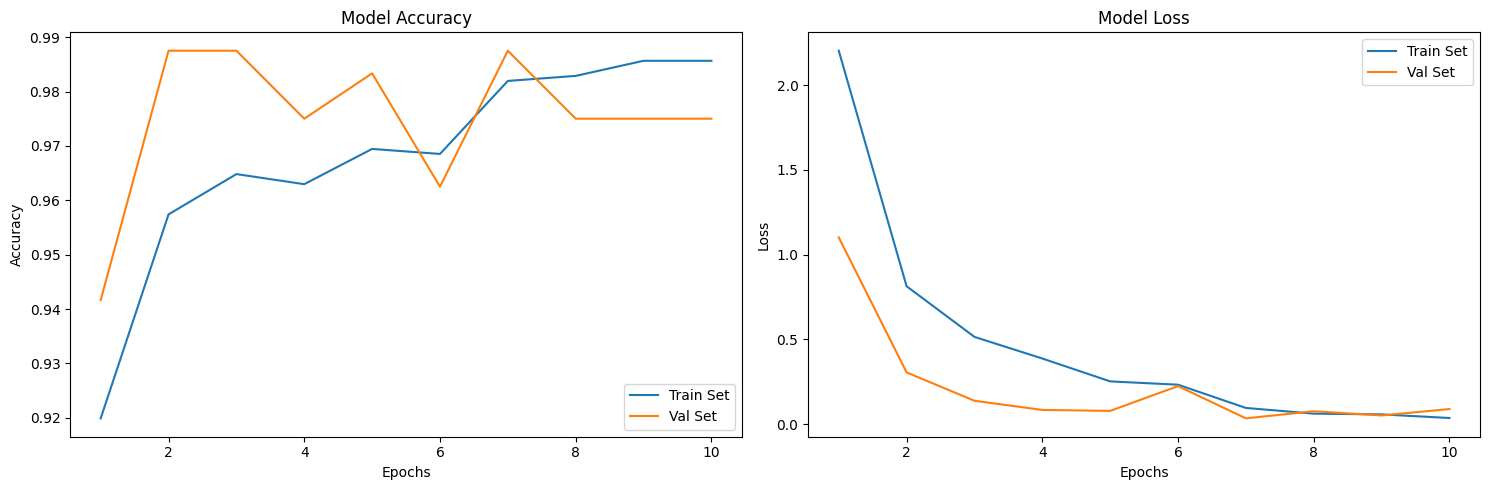

In [16]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(1, len(history.epoch) + 1)

plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Set')
plt.plot(epochs_range, val_acc, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Set')
plt.plot(epochs_range, val_loss, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')

plt.tight_layout()
plt.show()

In [17]:
model.save("/content/drive/MyDrive/DLModel")

In [18]:
loss,acc = model.evaluate(test_data,verbose=1)
print("Test Accuracy: ",np.round(acc,2))

19/19 [==============================] - 113s 6s/step - loss: 0.1709 - accuracy: 0.9683
Test Accuracy:  0.97


In [19]:
# Make predictions on test data
predictions = model.predict(test_data)
predicted_labels = np.argmax(predictions, axis=1)
print(predicted_labels)
true_labels = test_data.classes
class_names = test_data.class_indices.keys()

19/19 [==============================] - 4s 166ms/step
[0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 1 0
 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0
 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 

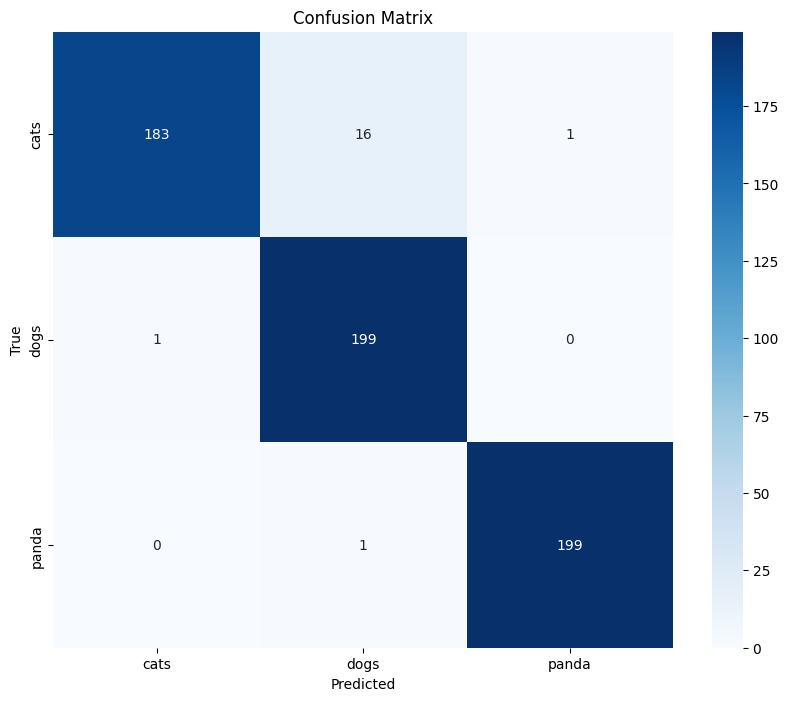

In [20]:
# Plot confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(10, 8))
sn.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [21]:
# Generate classification report
print("Classification Report:")
print(classification_report(true_labels, predicted_labels, target_names=class_names, digits = 4))

Classification Report:
              precision    recall  f1-score   support

        cats     0.9946    0.9150    0.9531       200
        dogs     0.9213    0.9950    0.9567       200
       panda     0.9950    0.9950    0.9950       200

    accuracy                         0.9683       600
   macro avg     0.9703    0.9683    0.9683       600
weighted avg     0.9703    0.9683    0.9683       600



In [22]:
# Load pre-trained model as a base model

base_model = MobileNetV2(include_top=False,
                   weights='imagenet',
                   input_shape=input_shape)

In [23]:
# Free the convolutional base of the model
base_model.trainable = False

In [24]:
# Add classificiation layer on top of the base model

model = Sequential([
    base_model,
    Flatten(),
    Dense(256, activation='relu'),
    Dense(num_class, activation='softmax')
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Func  (None, 7, 7, 1280)        2257984   
 tional)                                                         
                                                                 
 flatten_1 (Flatten)         (None, 62720)             0         
                                                                 
 dense_2 (Dense)             (None, 256)               16056576  
                                                                 
 dense_3 (Dense)             (None, 3)                 771       
                                                                 
Total params: 18315331 (69.87 MB)
Trainable params: 16057347 (61.25 MB)
Non-trainable params: 2257984 (8.61 MB)
_________________________________________________________________


In [29]:
# Compile the model

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [30]:
history = model.fit(train_data,
                    epochs = 10,
                    validation_data = validation_data,
                    batch_size = batch_size,
                    verbose = 1)

Epoch 1/10
68/68 [==============================] - 46s 625ms/step - loss: 2.5785 - accuracy: 0.9269 - val_loss: 1.3008 - val_accuracy: 0.9583
Epoch 2/10
68/68 [==============================] - 41s 601ms/step - loss: 1.3071 - accuracy: 0.9565 - val_loss: 0.8468 - val_accuracy: 0.9708
Epoch 3/10
68/68 [==============================] - 43s 638ms/step - loss: 1.5150 - accuracy: 0.9519 - val_loss: 1.6290 - val_accuracy: 0.9417
Epoch 4/10
68/68 [==============================] - 41s 599ms/step - loss: 0.4334 - accuracy: 0.9699 - val_loss: 0.6002 - val_accuracy: 0.9667
Epoch 5/10
68/68 [==============================] - 41s 607ms/step - loss: 0.3804 - accuracy: 0.9782 - val_loss: 0.2257 - val_accuracy: 0.9708
Epoch 6/10
68/68 [==============================] - 41s 606ms/step - loss: 0.2225 - accuracy: 0.9819 - val_loss: 0.1311 - val_accuracy: 0.9792
Epoch 7/10
68/68 [==============================] - 43s 629ms/step - loss: 0.1866 - accuracy: 0.9806 - val_loss: 0.2218 - val_accuracy: 0.9750

In [31]:
for i, layer in enumerate(base_model.layers):
    print(i, layer.name)

0 input_2
1 Conv1
2 bn_Conv1
3 Conv1_relu
4 expanded_conv_depthwise
5 expanded_conv_depthwise_BN
6 expanded_conv_depthwise_relu
7 expanded_conv_project
8 expanded_conv_project_BN
9 block_1_expand
10 block_1_expand_BN
11 block_1_expand_relu
12 block_1_pad
13 block_1_depthwise
14 block_1_depthwise_BN
15 block_1_depthwise_relu
16 block_1_project
17 block_1_project_BN
18 block_2_expand
19 block_2_expand_BN
20 block_2_expand_relu
21 block_2_depthwise
22 block_2_depthwise_BN
23 block_2_depthwise_relu
24 block_2_project
25 block_2_project_BN
26 block_2_add
27 block_3_expand
28 block_3_expand_BN
29 block_3_expand_relu
30 block_3_pad
31 block_3_depthwise
32 block_3_depthwise_BN
33 block_3_depthwise_relu
34 block_3_project
35 block_3_project_BN
36 block_4_expand
37 block_4_expand_BN
38 block_4_expand_relu
39 block_4_depthwise
40 block_4_depthwise_BN
41 block_4_depthwise_relu
42 block_4_project
43 block_4_project_BN
44 block_4_add
45 block_5_expand
46 block_5_expand_BN
47 block_5_expand_relu
48 b

In [32]:
# Fine-tune the layers
# Defines how many layers to freeze during training.
# Layers in the convolutional base are switched from trainable to non-trainable

fine_tune = 15
for layer in base_model.layers[:fine_tune]:
            layer.trainable = False

In [33]:
model2 = Sequential([
    base_model,
    Flatten(),
    Dense(256, activation='relu'),
    Dense(num_class, activation='softmax')
])

model2.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Func  (None, 7, 7, 1280)        2257984   
 tional)                                                         
                                                                 
 flatten_2 (Flatten)         (None, 62720)             0         
                                                                 
 dense_4 (Dense)             (None, 256)               16056576  
                                                                 
 dense_5 (Dense)             (None, 3)                 771       
                                                                 
Total params: 18315331 (69.87 MB)
Trainable params: 16057347 (61.25 MB)
Non-trainable params: 2257984 (8.61 MB)
_________________________________________________________________


In [36]:
model2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [37]:
history = model2.fit(train_data,
                    epochs = 10,
                    validation_data = validation_data,
                    batch_size = batch_size,
                    verbose = 1)

Epoch 1/10
68/68 [==============================] - 45s 621ms/step - loss: 2.2131 - accuracy: 0.9148 - val_loss: 2.1714 - val_accuracy: 0.9417
Epoch 2/10
68/68 [==============================] - 42s 623ms/step - loss: 1.0906 - accuracy: 0.9532 - val_loss: 0.5194 - val_accuracy: 0.9708
Epoch 3/10
68/68 [==============================] - 41s 605ms/step - loss: 0.3617 - accuracy: 0.9736 - val_loss: 0.1677 - val_accuracy: 0.9792
Epoch 4/10
68/68 [==============================] - 41s 600ms/step - loss: 0.3874 - accuracy: 0.9718 - val_loss: 0.5872 - val_accuracy: 0.9583
Epoch 5/10
68/68 [==============================] - 41s 607ms/step - loss: 0.3711 - accuracy: 0.9625 - val_loss: 0.0600 - val_accuracy: 0.9708
Epoch 6/10
68/68 [==============================] - 42s 620ms/step - loss: 0.2067 - accuracy: 0.9764 - val_loss: 0.0321 - val_accuracy: 0.9917
Epoch 7/10
68/68 [==============================] - 41s 598ms/step - loss: 0.1606 - accuracy: 0.9782 - val_loss: 0.2212 - val_accuracy: 0.9667

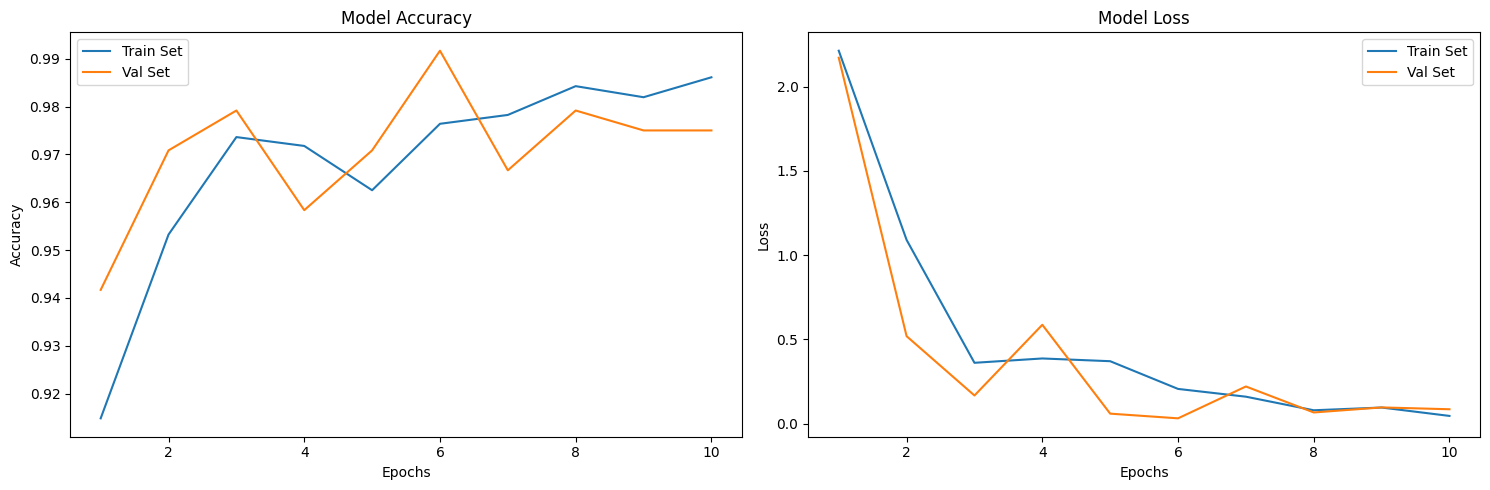

In [38]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(1, len(history.epoch) + 1)

plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Set')
plt.plot(epochs_range, val_acc, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Set')
plt.plot(epochs_range, val_loss, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')

plt.tight_layout()
plt.show()

In [52]:
model2.save("/content/drive/MyDrive/DLModel_finetune.h5")


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [53]:
# Model Evaluation
loss,acc = model2.evaluate(test_data,verbose=1)
print("Test Accuracy: ",np.round(acc,2))

19/19 [==============================] - 7s 165ms/step - loss: 0.1118 - accuracy: 0.9683
Test Accuracy:  0.97


In [54]:
# Make predictions on test data
predictions = model2.predict(test_data)
predicted_labels = np.argmax(predictions, axis=1)
print(predicted_labels)
true_labels = test_data.classes
class_names = test_data.class_indices.keys()

19/19 [==============================] - 5s 207ms/step
[0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0
 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0
 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 

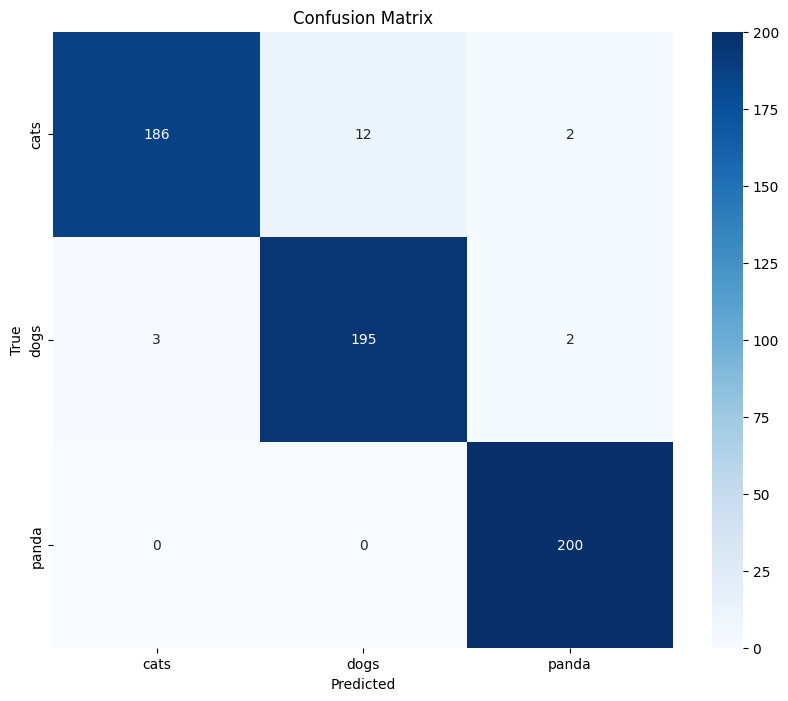

In [55]:
# Plot confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(10, 8))
sn.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [56]:
# Generate classification report
print("Classification Report:")
print(classification_report(true_labels, predicted_labels, target_names=class_names, digits = 4))


Classification Report:
              precision    recall  f1-score   support

        cats     0.9841    0.9300    0.9563       200
        dogs     0.9420    0.9750    0.9582       200
       panda     0.9804    1.0000    0.9901       200

    accuracy                         0.9683       600
   macro avg     0.9688    0.9683    0.9682       600
weighted avg     0.9688    0.9683    0.9682       600



In [57]:
class_names = ['cats', 'dogs', 'panda']
model = load_model("/content/drive/MyDrive/DLModel_finetune.h5") # path to the saved model

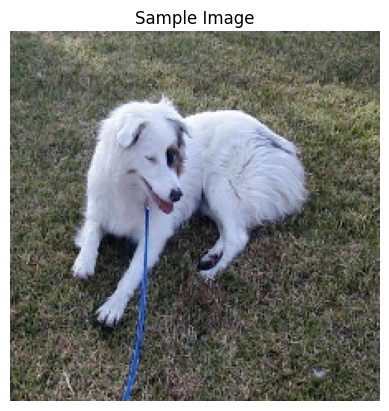

1/1 [==============================] - 3s 3s/step
1
Predicted Class: dogs


In [60]:
path = "/content/drive/MyDrive/test/dogs/dogs_00008.jpg" # Path to single image
img = image.load_img(path, target_size=(img_height, img_width)) # Load image

# Display the loaded image
plt.imshow(img)
plt.title('Sample Image')
plt.axis('off')
plt.show()

img_array = image.img_to_array(img) # Convert image to array
img_array = np.expand_dims(img_array, axis = 0) # Create a batch
img_array = img_array / 255 # Rescale

# make prediction
prediction = model.predict(img_array)
predicted_class_index = np.argmax(prediction)
print(predicted_class_index)
predicted_class = class_names[predicted_class_index]
print("Predicted Class:", predicted_class)

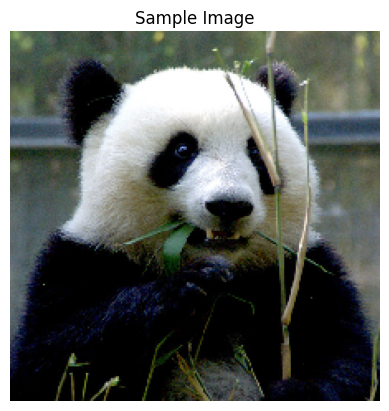

1/1 [==============================] - 0s 37ms/step
2
Predicted Class: panda


In [62]:
path = "/content/drive/MyDrive/test/panda/panda_00021.jpg" # Path to single image
img = image.load_img(path, target_size=(img_height, img_width)) # Load image

# Display the loaded image
plt.imshow(img)
plt.title('Sample Image')
plt.axis('off')
plt.show()

img_array = image.img_to_array(img) # Convert image to array
img_array = np.expand_dims(img_array, axis = 0) # Create a batch
img_array = img_array / 255 # Rescale

# make prediction
prediction = model.predict(img_array)
predicted_class_index = np.argmax(prediction)
print(predicted_class_index)
predicted_class = class_names[predicted_class_index]
print("Predicted Class:", predicted_class)